In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dropout, Dense, Flatten,GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from itertools import chain


In [7]:

try:
    with open('corpus_all.txt', 'r', encoding='utf-8') as file:
        lines = []  # Empty list to store the lines
        for line in file:
            lines.append(line.strip())  # Append the line to the list, removing any leading/trailing whitespace
    
    with open('stopwords-bn.txt', 'r', encoding='utf-8') as test:
        stopwords_bn = test.readlines()
        # the above stopwords contains newline \n
        stop_bn = []

        for word in stopwords_bn:
            stop_bn.append(word.rstrip("\r\n"))
            
except FileNotFoundError:
    print("File not found. Please check the file path and try again.")

#file_path = 'corpus_all.txt'  # Replace with the actual path to your text file
first_words = []  # Empty list to store the first words

try:
    for line in lines:
        words = line.strip().split()  # Split the line into words
        if words:
            first_word = words[0]  # Get the first word
            first_words.append(first_word)  # Append the first word to the list

except FileNotFoundError:
    print("File not found. Please check the file path and try again.")


# Define the status levels
status_levels = ["happy","angry","fear","disgust","sad","surprise",]

# Initialize a list to store the extracted status levels and sentences
extracted_data = []

# Iterate over the texts
for text in lines:
    # Initialize variables to store the extracted status level and sentence
    status = ""
    sentence = ""

    # Iterate over the status levels
    for level in status_levels:
        if level in text:
            # Split the text based on the status level
            split_text = text.split(level, 1)

            # Extract the status level and sentence
            status = level
            sentence = split_text[1].strip()
            break

    # Append the extracted status level and sentence to the list
    extracted_data.append({"Status": status, "Sentence": sentence})
    
df = pd.DataFrame(extracted_data)

In [8]:
def text_pre_processing(text):
    #remove stop words from the text
    text = ' '.join(word for word in text.split() if word not in stop_bn)
    #remove punctuation from the text
    text = re.sub(r'[^\w\s]', '', text)
    #remove numbers from the text
    text = re.sub(r'[0-9]', '', text)
    #remove extra spaces from the text
    text = re.sub(' +', ' ', text)
    return text

df['Sentence'] = df['Sentence'].apply(text_pre_processing)

In [9]:
df

,Status,Sentence
0,sad,বরবর মননয পরধনমনতর গণপরজতনতর বলদশ সরকর মননয পর...
1,sad,তদনত লভ তদনতর হয়ছ মন রজনতক শকতর তদনত পরব সমনয ...
2,angry,দশক মধযম আয়র দশ রপনতর মগর মলকর দশ পরনত হচছ
3,happy,গরবত মসলম সগরম যদধ চর রণবর আললহ ছর নচ শর নরয় ত...
4,angry,রতর বল কসর সকল
...,...,...
6284,surprise,ভরত পরতদন ১৮ ট রপ কইস এনটর
6285,surprise,সবধন দশ
6286,sad,সবধন দশর নগরক হয় পরধন
6287,angry,চদলম দদ পয়স


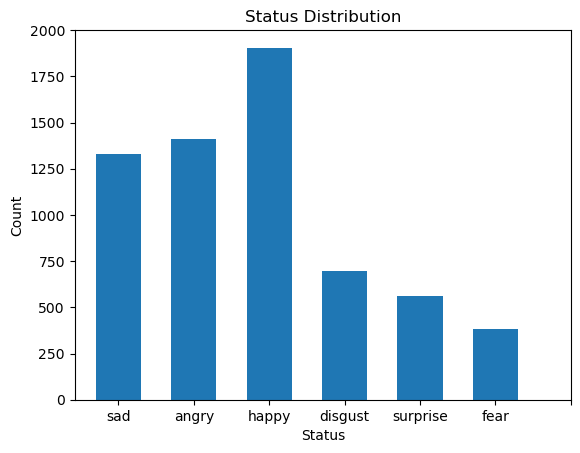

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(df['Status'], bins=[0, 1, 2, 3, 4, 5, 6], align='left', rwidth=0.6)
plt.xticks([0, 1, 2, 3, 4, 5, 6])
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status Distribution')
plt.show()

In [11]:
# Separate sentences and sentiments
sentences = df['Sentence'].values
sentiments = df['Status'].values

# Map sentiment labels to numerical values
sentiment_mapping = {'happy': 0, 'angry': 1, 'fear': 2, 'disgust': 3, 'sad': 4, 'surprise': 5}
sentiments = [sentiment_mapping[s] for s in sentiments]

# Split the data into training and testing sets
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, sentiments, test_size=0.2, random_state=42)

# Set the maximum number of words to keep in the vocabulary
max_words = 5000

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences_train)

# Convert sentences to sequences of integers
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences to ensure they have the same length
max_sequence_length = max(len(seq) for seq in X_train)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

# Convert sentiment labels to one-hot encoded vectors
y_train = to_categorical(y_train,6)
y_test = to_categorical(y_test,6)


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train:", X_train)
print("y_train:", y_train)

X_train shape: (5031, 463)
y_train shape: (5031, 6)
X_train: [[   0    0    0 ...    0    0    7]
 [   0    0    0 ...   41   98    5]
 [   0    0    0 ... 1146  424    4]
 ...
 [   0    0    0 ... 2065   13 3133]
 [   0    0    0 ...  350 1113  220]
 [   0    0    0 ...  128  889   31]]
y_train: [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]]


In [13]:
# Create the CNN model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 463, 100)          1139900   
                                                                 
 conv1d (Conv1D)             (None, 459, 128)          64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1,204,802
Trainable params: 1,204,802
Non-trainable params: 0
_________________________________________________________________


In [14]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
32/32 [==============================] - 82s 2s/step - loss: 1.6844 - accuracy: 0.2910 - val_loss: 1.6315 - val_accuracy: 0.3108
Epoch 2/10
32/32 [==============================] - 70s 2s/step - loss: 1.5798 - accuracy: 0.4031 - val_loss: 1.5447 - val_accuracy: 0.4022
Epoch 3/10
32/32 [==============================] - 64s 2s/step - loss: 1.3951 - accuracy: 0.5293 - val_loss: 1.4106 - val_accuracy: 0.4638
Epoch 4/10
32/32 [==============================] - 62s 2s/step - loss: 1.1566 - accuracy: 0.6001 - val_loss: 1.3757 - val_accuracy: 0.4767
Epoch 5/10
32/32 [==============================] - 63s 2s/step - loss: 0.9338 - accuracy: 0.6598 - val_loss: 1.4243 - val_accuracy: 0.4707
Epoch 6/10
32/32 [==============================] - 67s 2s/step - loss: 0.7205 - accuracy: 0.7771 - val_loss: 1.5151 - val_accuracy: 0.4508
Epoch 7/10
32/32 [==============================] - 61s 2s/step - loss: 0.5256 - accuracy: 0.8728 - val_loss: 1.6369 - val_accuracy: 0.4369
Epoch 8/10
32/32 [==

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


In [16]:
# make a prediction
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# print the classification report
print(classification_report(y_test, y_pred))


40/40 [==============================] - 7s 155ms/step
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       391
           1       0.45      0.55      0.49       268
           2       0.12      0.05      0.07        66
           3       0.26      0.16      0.20       141
           4       0.38      0.41      0.39       278
           5       0.24      0.18      0.20       114

    accuracy                           0.46      1258
   macro avg       0.35      0.34      0.34      1258
weighted avg       0.43      0.46      0.44      1258



In [17]:
# make a cnn model with 2 convolutional layers and 2 dense layers with dropout layers
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 463, 100)          1139900   
                                                                 
 conv1d_1 (Conv1D)           (None, 459, 128)          64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
# Make hybrid model with 2 convolutional layers and 2 dense layers with dropout layers
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))



